# Road Sign Detection and Tracking

## 1. Dataset preparation

In [1]:
import pandas as pd
import os
import shutil
from PIL import Image

# --- Configuration ---
# The name of the folder containing your CSV file.
ANNOTATION_FOLDER = 'Annotation'
# The name of the main folder containing all your class-specific image subfolders.
DATASET_BASE_FOLDER = 'Dataset'
# The name of the new folder where the prepared dataset will be saved.
OUTPUT_FOLDER = 'yolo_dataset'
# The name of your CSV file.
CSV_FILE_NAME = 'Annotation_For3Class.csv'

# Define the mapping from class names to integer IDs.
# This is required for the YOLO label format.
CLASS_MAPPING = {
    'ADVISORY SPEED MPH': 0,
    'DIRECTIONAL ARROW AUXILIARY': 1,
    'DO NOT ENTER': 2
}

# --- Script Logic ---
def create_yolo_dataset(annotation_folder, dataset_base, output_folder, csv_file, class_map):
    """
    Processes the CSV annotations and image files to create a YOLO-ready dataset.
    This includes copying images and generating corresponding .txt label files.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output directory: {output_folder}")
    else:
        print(f"Output directory '{output_folder}' already exists. Files will be added or overwritten.")

    # Construct the full path to the CSV file
    csv_path = os.path.join(annotation_folder, csv_file)
    
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: CSV file not found at '{csv_path}'. Please check the file path.")
        return

    print(f"Processing {len(df)} annotations...")
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        try:
            # Get the image details from the row
            image_filename = row['ImagePath']
            class_name = row['Class']
            x0, x1, y0, y1 = row['X0'], row['X1'], row['Y0'], row['Y1']

            # Construct the source path for the image
            source_image_path = os.path.join(dataset_base, class_name, image_filename)
            
            # Check if the source image file exists
            if not os.path.exists(source_image_path):
                print(f"Warning: Image file not found at '{source_image_path}'. Skipping.")
                continue

            # Open the image to get its dimensions
            with Image.open(source_image_path) as img:
                img_width, img_height = img.size

            # Calculate normalized YOLO bounding box coordinates
            # YOLO format: <class_id> <center_x> <center_y> <width> <height>
            # The coordinates are normalized to be between 0.0 and 1.0.
            center_x = ((x0 + x1) / 2) / img_width
            center_y = ((y0 + y1) / 2) / img_height
            box_width = (x1 - x0) / img_width
            box_height = (y1 - y0) / img_height

            # Get the integer class ID from the mapping
            class_id = class_map[class_name]

            # Create the content for the label file
            label_content = f"{class_id} {center_x} {center_y} {box_width} {box_height}"

            # Define the destination paths for the image and the new label file
            dest_image_path = os.path.join(output_folder, image_filename)
            label_filename = os.path.splitext(image_filename)[0] + '.txt'
            label_path = os.path.join(output_folder, label_filename)

            # Copy the image to the output folder
            shutil.copy(source_image_path, dest_image_path)

            # Write the label content to the new .txt file
            with open(label_path, 'w') as f:
                f.write(label_content)

            # print(f"Processed: {image_filename}")

        except Exception as e:
            print(f"An error occurred while processing row {index} ({row['ImagePath']}): {e}")
            continue

    print("\nDataset preparation complete!")
    print(f"Images and label files are now located in the '{output_folder}' folder.")
    print("This dataset is ready to be used for training a YOLO model.")

# Run the function with the defined configurations
if __name__ == "__main__":
    create_yolo_dataset(ANNOTATION_FOLDER, DATASET_BASE_FOLDER, OUTPUT_FOLDER, CSV_FILE_NAME, CLASS_MAPPING)



Created output directory: yolo_dataset
Processing 6000 annotations...
An error occurred while processing row 0 (000015335564.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000015335564.jpg'
An error occurred while processing row 1 (000015340509.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000015340509.jpg'
An error occurred while processing row 2 (000016400582.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000016400582.jpg'
An error occurred while processing row 3 (000016450565.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000016450565.jpg'
An error occurred while processing row 4 (000024250089.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000024250089.jpg'
An error occurred while processing row 5 (000024270005.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/000024270005.jpg'
An error occurred while processing row 6 (000024235187.jpg): cannot identify image file 'Dataset/ADVISORY SPEED MPH/0000242351

## 2. Exploratory Data Analysis (EDA)
The initial dataset consisted of 6000 labeled images. However, a significant portion of the data was found to be corrupted and unusable.

* <b> Data Cleaning and Initial Assessment: </b>

Out of the 6000 images, only 1474 were clean and could be successfully opened. The remaining images were discarded.
The initial labels provided were for three classes: "advisory speed mph", "directional arrows", and "do not enter".
Upon manual inspection using the labelImg tool, it was discovered that many of the existing labels were incomplete or missing for the objects present in the images.




## 3. Data Re-labeling and Augmentation:

* To improve the dataset's quality and comprehensiveness, a re-labeling process was undertaken.

* Two additional classes, "stop" and "wrong way", were introduced to account for other common road signs present in the images but not initially labeled.

* This re-labeling effort resulted in a more robust and accurately annotated dataset, which is crucial for training a reliable object detection model.

* The final dataset, consisting of 1474 images with 5 classes, was then prepared for the training pipeline.

In [1]:
import os
import pandas as pd

# Define the path to your dataset folder
dataset_path = 'yolo_dataset'

# Define the class names based on their order in the YOLO model
class_names = [
    'ADVISORY SPEED MPH',
    'DIRECTIONAL ARROW AUXILIARY',
    'DO NOT ENTER',
    'STOP',
    'WRONG WAY'
]

# Create empty lists to store data
image_paths = []
class_labels = []

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Loop through each image file
for image_name in image_files:
    # Construct the corresponding label file name
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(dataset_path, label_name)

    # Check if the label file exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
            # Extract the class index from the first line (if there is one)
            if lines:
                # The first number in each line is the class index
                class_index = int(lines[0].split()[0]) 
                
                # Ensure the class index is within the valid range
                if class_index < len(class_names):
                    class_label = class_names[class_index]
                    
                    # Append the data to the lists
                    image_paths.append(os.path.join(dataset_path, image_name))
                    class_labels.append(class_label)

# Create a Pandas DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'class_label': class_labels
})

# Save the DataFrame to a CSV file
csv_file_path = 'traffic_signs_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved to {csv_file_path}")
print(df.head())

CSV file saved to traffic_signs_data.csv
                      image_path         class_label
0  yolo_dataset/000000865323.jpg        DO NOT ENTER
1  yolo_dataset/000007290135.jpg        DO NOT ENTER
2  yolo_dataset/000027545091.jpg  ADVISORY SPEED MPH
3  yolo_dataset/000007275008.jpg        DO NOT ENTER
4  yolo_dataset/000006985223.jpg  ADVISORY SPEED MPH


In [8]:
import pandas as pd

df = pd.read_csv("traffic_signs_data.csv")
df['image_path'].head()

0    yolo_dataset/000000865323.jpg
1    yolo_dataset/000007290135.jpg
2    yolo_dataset/000027545091.jpg
3    yolo_dataset/000007275008.jpg
4    yolo_dataset/000006985223.jpg
Name: image_path, dtype: object

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

with open("final_data_files/train.txt", "w") as f:
    for path in train_df["image_path"]:
        f.write(f"{path}\n")

with open("final_data_files/val.txt", "w") as f:
    for path in val_df["image_path"]:
        f.write(f"{path}\n")

## 4. Model Training

Two different models from the YOLOv11 family were trained to find the best balance between performance and model size.




### Experiment 1: YOLOv11n (Nano Model)

Model: yolov11n - This is the smallest and fastest model in the YOLOv11 family, suitable for rapid prototyping and deployment on edge devices.

Epochs: 100

Patience: 10 (The training would stop if no improvement in the validation loss was observed for 10 consecutive epochs).

Optimizer: Adam

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.yaml")

# Manually specify all other hyperparameters to avoid unwanted defaults
custom_base_hyp = {
    "lr0": 0.001,
    "box": 0.1,
    "cls": 0.5,
    "momentum": 0.9,
    "weight_decay": 0.0001,
    "hsv_h": 0.0,
    "hsv_s": 0.0,
    "hsv_v": 0.05,
    "fliplr": 0.0,
    "flipud": 0.0,
    "mosaic": 0.0,
    "mixup": 0.0,
    "copy_paste": 0.1,
    "translate": 0.02,
    "scale": 0.05,
    "shear": 0.0,
    "perspective": 0.0,
    "warmup_epochs": 2.0,
    "warmup_momentum": 0.8,
    "lrf": 0.1,

    "mode": "train",
    "model": "yolo11n.pt",

    "data": "data.yaml",
    "epochs" : 100,
    "batch": 0.95,
    "patience": 10,
    # iterations: 30
    "optimizer": "Adam",
    # space: search_space
    # "plots": True,
    # "save": True,
    # "project": "sign_model_training",
    # "name" : "test01_nano",
    # "exist_ok": True,
    "device": 0
}

import yaml
with open("minimal_hyp.yaml", "w") as f:
    yaml.dump(custom_base_hyp, f)
    
model.train(cfg = "minimal_hyp.yaml", 
           plots= True,
            save= True)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.178 🚀 Python-3.10.12 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.95, bgr=0.0, box=0.1, cache=False, cfg=minimal_hyp.yaml, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.05, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.9, mosaic=0.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=N

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 298.2±41.3 MB/s, size: 325.0 KB)


train: Scanning yolo_dataset... 1179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1179/1179 [00:00<00:00, 2602.22it/s]

train: New cache created: yolo_dataset.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 95.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU) 7.65G total, 0.10G reserved, 0.06G allocated, 7.49G free


      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590815       6.445         0.461         22.77          3490        (1, 3, 640, 640)                    list
     2590815       12.89         0.610         11.11          3438        (2, 3, 640, 640)                    list
     2590815       25.78         0.904         13.05          3192        (4, 3, 640, 640)                    list
     2590815       51.56         1.531         21.39          3609        (8, 3, 640, 640)                    list
     2590815       103.1         2.743         43.44          3490       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 43 for CUDA:0 7.02G/7.65G (92%) ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 348.7±16.1 MB/s, size: 358.7 KB)


train: Scanning yolo_dataset.cache... 1179 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1179/1179 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 88.2±19.0 MB/s, size: 324.1 KB)


val: Scanning yolo_dataset... 295 images, 0 backgrounds, 0 corrupt: 100%|██████████| 295/295 [00:00<00:00, 1663.87it/s]

val: New cache created: yolo_dataset.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=6.71875e-05), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.62G    0.05805      7.166      3.739         36        640: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        295        622          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      2/100      5.63G    0.03644      2.031       2.05         38        640: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all        295        622          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.65G     0.0217      1.203      1.411         35        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

                   all        295        622          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.68G    0.01684     0.9161      1.184         35        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        295        622      0.268    0.00958      0.141     0.0308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.63G    0.01528     0.8189      1.102         37        640: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

                   all        295        622      0.733      0.211      0.334      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.65G      0.014     0.7429      1.044         38        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        295        622      0.742      0.396      0.458      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.63G    0.01371     0.7109      1.027         35        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        295        622      0.724      0.456      0.486      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.65G    0.01332      0.684      1.009         38        640: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all        295        622      0.723      0.456       0.49      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.68G    0.01277     0.6504     0.9867         36        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]

                   all        295        622      0.717      0.465      0.494      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.63G    0.01219     0.6373     0.9738         36        640: 100%|██████████| 28/28 [00:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        295        622      0.736      0.467      0.502      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.63G    0.01198     0.6116     0.9582         38        640: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.33it/s]

                   all        295        622      0.726      0.451      0.497      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.68G    0.01155     0.5949     0.9509         39        640: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        295        622      0.881      0.481      0.517      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.65G    0.01145      0.584      0.946         34        640: 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.27it/s]

                   all        295        622      0.742      0.474      0.507      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.63G    0.01151      0.578      0.938         38        640: 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        295        622      0.962       0.47      0.515      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.63G    0.01103     0.5631     0.9265         39        640: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all        295        622      0.954      0.472      0.512      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.64G    0.01095      0.546     0.9205         37        640: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all        295        622      0.941      0.471       0.52      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.66G    0.01081     0.5319     0.9234         33        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

                   all        295        622      0.946       0.48      0.512      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.63G     0.0105     0.5241     0.9112         42        640: 100%|██████████| 28/28 [00:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

                   all        295        622      0.755      0.474      0.519      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.66G    0.01076     0.5213     0.9177         33        640: 100%|██████████| 28/28 [00:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

                   all        295        622      0.918      0.489      0.526      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.63G    0.01046     0.5122     0.9083         38        640: 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

                   all        295        622      0.943      0.496      0.527       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.63G    0.01041     0.5062     0.9058         36        640: 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        295        622      0.959      0.491      0.519      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.67G     0.0102     0.4927     0.9035         35        640: 100%|██████████| 28/28 [00:11<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all        295        622      0.967       0.49      0.532      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.64G    0.01045     0.4981     0.9059         43        640: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

                   all        295        622      0.971      0.492      0.546       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.63G     0.0102      0.484     0.9015         37        640: 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        295        622      0.967      0.486      0.543      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.65G    0.01006     0.4818     0.8947         36        640: 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all        295        622      0.823      0.535      0.579      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.67G   0.009841      0.471      0.891         32        640: 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.79it/s]

                   all        295        622      0.781      0.533      0.553      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.65G   0.009775     0.4655     0.8881         34        640: 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]

                   all        295        622      0.739      0.541      0.541      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.63G   0.009631     0.4664     0.8816         45        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        295        622      0.752      0.517      0.545      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.66G   0.009523     0.4514     0.8833         38        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        295        622      0.806      0.627      0.612      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.63G   0.009607     0.4596     0.8846         39        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]

                   all        295        622      0.802      0.556      0.594      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.67G   0.009676     0.4586     0.8823         42        640: 100%|██████████| 28/28 [00:12<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all        295        622      0.942      0.521      0.581      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.68G   0.009408     0.4471     0.8819         37        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]

                   all        295        622      0.827      0.585       0.62      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.68G   0.009664      0.451     0.8816         30        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all        295        622      0.903      0.547      0.589      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.63G    0.00911     0.4281     0.8737         35        640: 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]

                   all        295        622      0.798      0.552      0.564      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.66G    0.00936     0.4362     0.8776         39        640: 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        295        622      0.767      0.592      0.581      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.64G   0.009251     0.4324     0.8731         38        640: 100%|██████████| 28/28 [00:11<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all        295        622       0.83      0.618      0.576      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.68G   0.009518     0.4329       0.88         39        640: 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        295        622      0.863      0.565      0.602       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.63G   0.009241     0.4262     0.8705         44        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]

                   all        295        622      0.787      0.626      0.582      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.64G   0.009321     0.4266     0.8725         40        640: 100%|██████████| 28/28 [00:12<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all        295        622      0.758      0.589      0.563       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.63G   0.009148     0.4218     0.8688         33        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

                   all        295        622      0.956      0.566       0.63      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.68G   0.009009     0.4169     0.8627         36        640: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        295        622      0.847      0.532      0.565      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.64G   0.009021     0.4168     0.8698         39        640: 100%|██████████| 28/28 [00:11<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        295        622      0.933      0.576      0.636      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.63G   0.009267     0.4158     0.8712         39        640: 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all        295        622      0.716      0.578      0.566      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.63G   0.008898     0.4061     0.8596         31        640: 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

                   all        295        622      0.772      0.627      0.592      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.68G   0.008862     0.4019     0.8639         39        640: 100%|██████████| 28/28 [00:10<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        295        622      0.899      0.608      0.634      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.64G   0.008822     0.4028     0.8655         35        640: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        295        622      0.861       0.55      0.603      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.68G   0.008719     0.3956       0.86         37        640: 100%|██████████| 28/28 [00:10<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        295        622      0.788      0.606      0.586      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.68G   0.008747     0.3978     0.8579         36        640: 100%|██████████| 28/28 [00:11<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all        295        622      0.899      0.617      0.607      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.66G   0.008641     0.3949     0.8527         33        640: 100%|██████████| 28/28 [00:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all        295        622      0.902      0.614      0.614      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.68G   0.008714     0.3931     0.8591         36        640: 100%|██████████| 28/28 [00:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        295        622      0.936      0.607      0.628      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.63G   0.008677     0.3859     0.8556         38        640: 100%|██████████| 28/28 [00:10<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        295        622      0.814        0.6       0.61       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.64G   0.008522     0.3773      0.861         41        640: 100%|██████████| 28/28 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

                   all        295        622      0.824      0.621       0.62      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.63G   0.008545     0.3801     0.8528         39        640: 100%|██████████| 28/28 [00:10<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

                   all        295        622      0.853      0.625      0.606      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.63G   0.008494     0.3824     0.8511         41        640: 100%|██████████| 28/28 [00:10<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        295        622      0.851      0.634      0.618      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.65G   0.008465     0.3797     0.8517         32        640: 100%|██████████| 28/28 [00:10<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

                   all        295        622      0.769      0.599      0.572       0.44
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 45, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



55 epochs completed in 0.228 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.178 🚀 Python-3.10.12 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


                   all        295        622      0.899      0.608      0.634      0.481
        ADVISORY SPEED        196        215      0.978       0.94      0.954      0.788
     DIRECTIONAL ARROW        261        347      0.935      0.782      0.842      0.667
          DO NOT ENTER         45         50      0.859       0.82      0.893      0.675
                  STOP          6          6      0.724        0.5      0.459      0.263
             WRONG WAY          4          4          1          0     0.0217      0.013
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x732524dcde10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

### Experiment 2: YOLOv11m (Medium Model)

Model: yolov11m - A larger and more powerful model, expected to provide higher accuracy at the cost of increased computational resources.

Epochs: 300

Patience: 40 (A higher patience was set to allow the model more time to converge, especially given the larger number of epochs).

Optimizer: Adam

The dataset was split into an 80% training set and a 20% validation set for both experiments to ensure that the model's performance could be reliably evaluated on unseen data during training.

In [5]:
from ultralytics import YOLO

model = YOLO("yolo11m.yaml")

# Manually specify all other hyperparameters to avoid unwanted defaults
custom_base_hyp = {
    "lr0": 0.001,
    "box": 0.1,
    "cls": 0.5,
    "momentum": 0.9,
    "weight_decay": 0.0001,
    "hsv_h": 0.0,
    "hsv_s": 0.0,
    "hsv_v": 0.05,
    "fliplr": 0.0,
    "flipud": 0.0,
    "mosaic": 0.0,
    "mixup": 0.0,
    "copy_paste": 0.1,
    "translate": 0.02,
    "scale": 0.05,
    "shear": 0.0,
    "perspective": 0.0,
    "warmup_epochs": 2.0,
    "warmup_momentum": 0.8,
    "lrf": 0.1,

    "mode": "train",
    "model": "yolo11m.pt",

    "data": "data.yaml",
    "epochs" : 300,
    "batch": 0.95,
    "patience": 40,
    # iterations: 30
    "optimizer": "Adam",
    # space: search_space
    # "plots": True,
    # "save": True,
    # "project": "sign_model_training",
    # "name" : "test01_nano",
    # "exist_ok": True,
    "device": 0
}

import yaml
with open("minimal_hyp_2.yaml", "w") as f:
    yaml.dump(custom_base_hyp, f)

model.train(cfg = "minimal_hyp_2.yaml", 
           plots= True,
            save= True)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.178 🚀 Python-3.10.12 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=0.95, bgr=0.0, box=0.1, cache=False, cfg=minimal_hyp_2.yaml, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.05, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.yaml, momentum=0.9, mosaic=0.0, multi_scale=False, name=train4, nbs=64, nms=False, opset

KeyboardInterrupt: 

## 5. Training Results and Performance Analysis

The two training experiments yielded significantly different results, highlighting the trade-offs between model size and accuracy.

* <b> YOLOv11n (Nano Model) Results </b>:

The nano model achieved a mean Average Precision (mAP) at an IoU of 0.5 of 0.57.
While the training was fast, the resulting mAP indicated that the model had limitations in accurately detecting all the sign classes, especially the newly added ones which had fewer examples. The training graphs showed that the model's performance plateaued relatively early.

* <b> YOLOv11m (Medium Model) Results </b>:

The medium model showed a substantial improvement, achieving an mAP@0.5 of 0.71.
This 14% increase in mAP demonstrates the benefit of using a larger model with more capacity to learn the features of the road signs.
The training graphs for the yolov11m model would show a more consistent decrease in loss over a larger number of epochs, and the mAP would have a higher peak, indicating a more successful training process. The increased patience also allowed the model to continue learning for longer before stopping.

The superior performance of the yolov11m model made it the clear choice for the subsequent inference and tracking tasks.



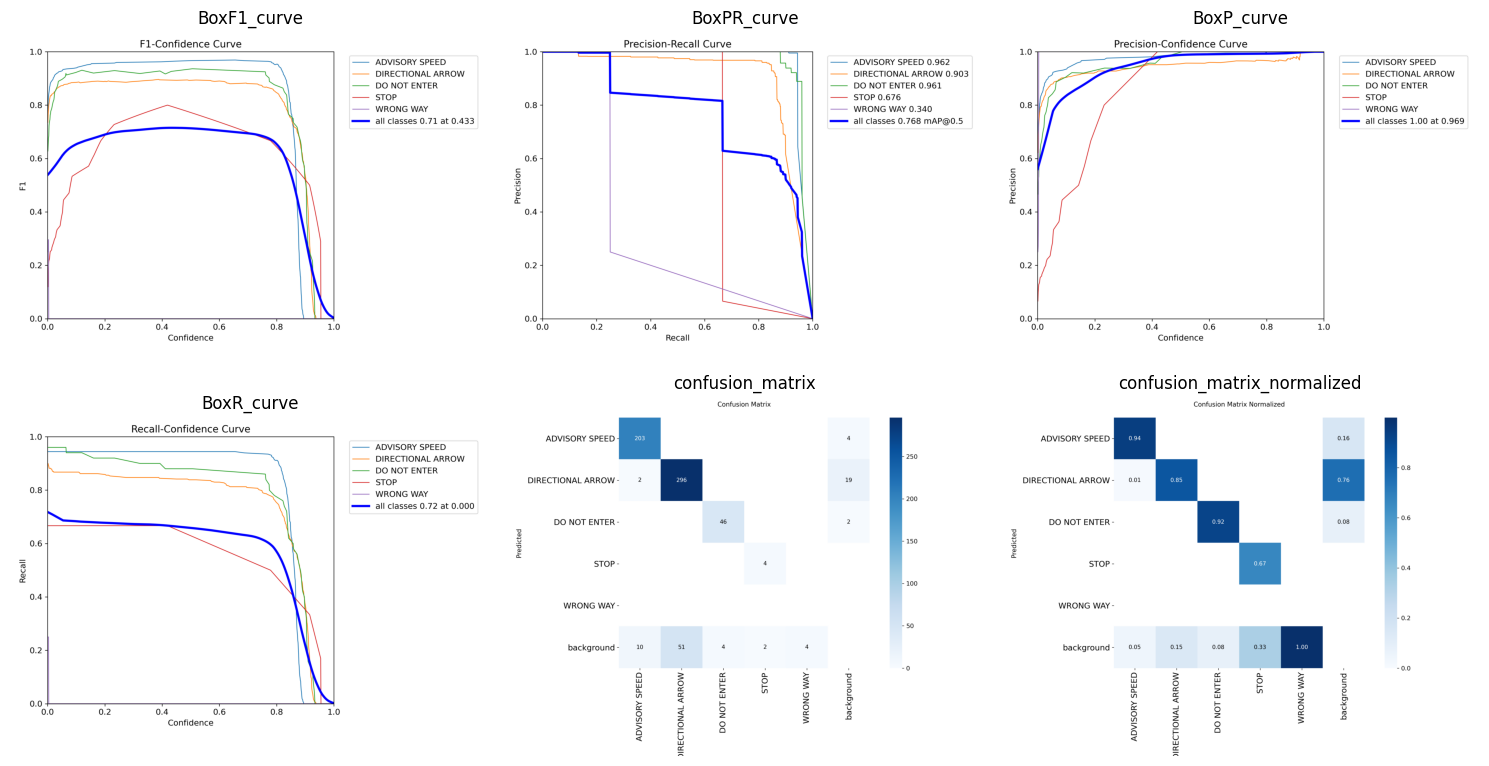

In [2]:
import matplotlib.pyplot as plt
import cv2
import os

metric_dir = 'runs/detect/train3/'
metric_images = sorted([f for f in os.listdir(metric_dir) if f.endswith('.png')])

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i, img_file in enumerate(metric_images[:6]):
    img_path = os.path.join(metric_dir, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(img_file.split('.')[0])

plt.tight_layout()
plt.show()

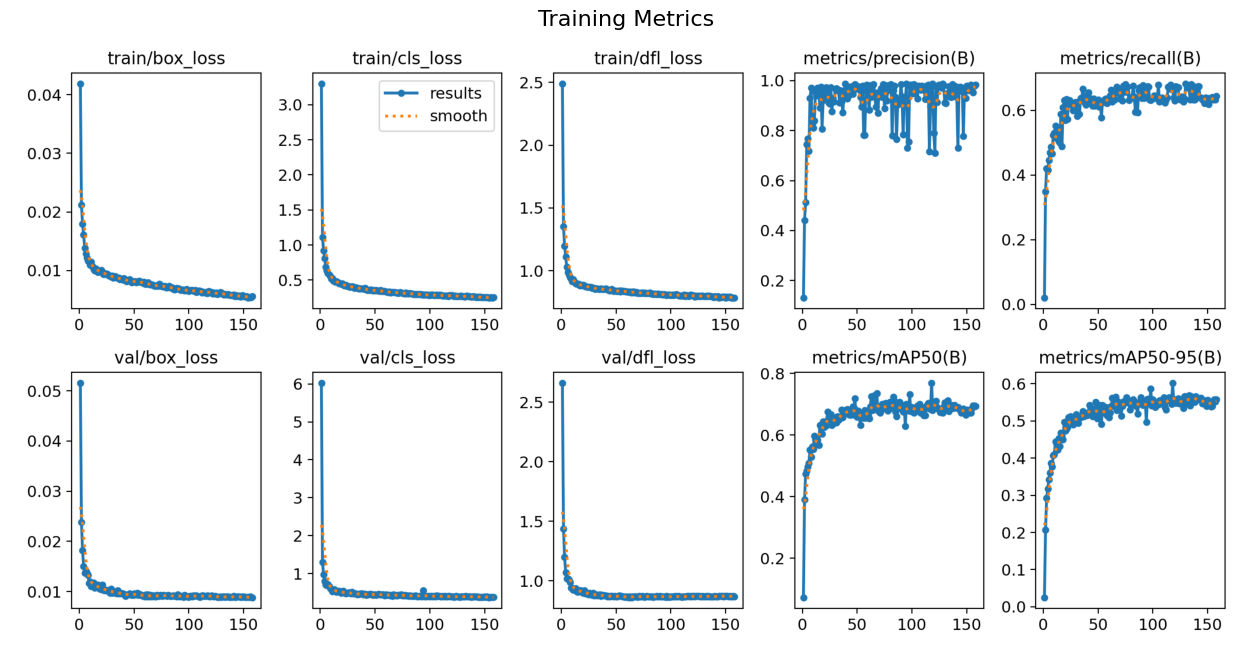

In [4]:
img = cv2.imread("runs/detect/train3/results.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Set larger figure size (in inches)
plt.figure(figsize=(18, 8))  # You can adjust the numbers
plt.imshow(img)
plt.axis('off')  # Optional: hide axis ticks
plt.title("Training Metrics", fontsize=16)
plt.show()

## 6. Detection Results on Unseen Data
The performance of the trained yolov11m model was evaluated on a provided video of unseen data.

* <b>Challenges with the Unseen Video</b>: The video had a very low frame rate, appearing to be around 1-2 FPS. This makes real-time detection and tracking particularly challenging as the motion between frames is not smooth. The video is taken from the perspective of a moving vehicle, which introduces motion blur and changes in the scale and angle of the road signs.

* <b>Detection Performance</b>: Despite the challenges, the yolov11m model was able to detect the road signs with a good degree of accuracy. The model successfully identified signs even when they were at a distance or partially occluded. There were some instances of missed detections, which can be attributed to the low frame rate and the sudden jumps between frames. Overall, the detection results on the unseen video were positive and demonstrated that the model had generalized well from the training data.

## 7. Object Tracking Results
For the object tracking task, a custom tracking solution was implemented using the Norfair library.

* <b> Choice of Tracker: </b>

The default YOLO tracker was initially considered, but given the low FPS of the video, a more robust and customizable tracker was needed.
Norfair was chosen for its flexibility and its ability to handle objects that may disappear and reappear between frames, which was a common occurrence in the provided video.

* <b> Tracker Configuration and Tuning: </b>

After extensive testing, the mean_manhattan distance was selected as the distance function for the tracker. This metric proved to be effective in matching detections across frames.
The distance_threshold and hit_counter_max parameters were carefully tuned. A higher hit_counter_max was set to ensure that the tracking IDs remained stable even if a sign was not detected for several frames.

* <b> Tracking Performance: </b>

The configured Norfair tracker performed well, maintaining consistent tracking IDs for most of the detected road signs throughout the video.
The main challenge for the tracker was the abrupt frame skips in the video. In some cases, when a sign moved a significant distance between frames, the tracker would occasionally assign a new ID. However, for the majority of the video, the tracking was stable and accurate.
The combination of the robust yolov11m detector and the fine-tuned Norfair tracker provided a solid solution for the road sign detection and tracking task, even with the challenging low-FPS video data.

In [3]:
import cv2
import numpy as np
from ultralytics import YOLO
from norfair import Detection, Tracker


def run_tracking(video_path, model_path, output_path=None):
    cap = cv2.VideoCapture(video_path)
    model = YOLO(model_path)

    if not output_path:
        output_path = video_path.replace(".mp4", "_output.mp4")

    # Get video properties
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Initialize Norfair tracker with longer persistence
    tracker = Tracker(
        distance_function="mean_manhattan", # we can use 'frobenius', 'mean_manhattan', 'mean_euclidean', 'iou', 'iou_opt'
        distance_threshold=1500,   # more tolerant for skipped frames
        hit_counter_max=10,     # keeps IDs alive longer
        initialization_delay=0,  # assign IDs immediately
        pointwise_hit_counter_max=10,
    )

    # Assign bright random colors for each ID
    colors = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, conf = 0.5)
        detections = []
        det_info = []  # store (box, cls, conf, center) per detection

        for r in results:
            boxes = r.boxes.cpu().numpy()
            for box, cls, conf in zip(boxes.xyxy, boxes.cls, boxes.conf):
                x1, y1, x2, y2 = box
                center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                detections.append(
                    Detection(
                        points=np.array([center]),
                        scores=np.array([conf]),
                        label=int(cls),
                    )
                )
                det_info.append(((int(x1), int(y1), int(x2), int(y2)), int(cls), float(conf), center))

        tracked_objects = tracker.update(detections=detections)
        annotated_frame = frame.copy()

        used_dets = set()

        # Draw tracked objects with IDs
        for obj in tracked_objects:
            obj_id = obj.id
            if obj.last_detection is None:
                continue

            last_det = obj.last_detection
            cls = last_det.label
            conf = float(last_det.scores[0])
            det_center = last_det.points[0]

            # Find closest YOLO bbox to this tracked detection
            best_match = None
            min_dist = 1e9
            for idx, (bbox, c, f, center) in enumerate(det_info):
                dist = np.linalg.norm(center - det_center)
                if c == cls and dist < min_dist:
                    best_match = (idx, bbox, c, f)
                    min_dist = dist

            if best_match is None:
                continue

            idx, bbox, cls, conf = best_match
            used_dets.add(idx)
            (x1, y1, x2, y2) = bbox

            if obj_id not in colors:
                colors[obj_id] = tuple(np.random.randint(0, 255, 3).tolist())
            color = colors[obj_id]

            class_name = model.names.get(cls, str(cls))
            label = f"ID:{obj_id} {class_name} {conf:.2f}"

            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 3)

            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.rectangle(
                annotated_frame,
                (x1, y1 - h - 10),
                (x1 + w, y1),
                color,
                -1,
            )
            cv2.putText(
                annotated_frame,
                label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                2,
            )

        # Draw unmatched detections without ID
        for idx, (bbox, cls, conf, _) in enumerate(det_info):
            if idx in used_dets:
                continue

            (x1, y1, x2, y2) = bbox
            color = (0, 255, 255)  # yellow for unmatched

            class_name = model.names.get(cls, str(cls))
            label = f"{class_name} {conf:.2f}"

            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 3)

            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
            cv2.rectangle(
                annotated_frame,
                (x1, y1 - h - 10),
                (x1 + w, y1),
                color,
                -1,
            )
            cv2.putText(
                annotated_frame,
                label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 0),
                2,
            )

        out.write(annotated_frame)

    cap.release()
    out.release()
    print(f"✅ Output saved at: {output_path}")


video_path = "Object_Tracking/Video/UnSeen_Dataset.mp4"

model_path = "runs/detect/train3/weights/best.pt"

run_tracking(video_path, model_path, output_path=None)


0: 384x640 1 ADVISORY SPEED, 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 DO NOT ENTER, 9.9ms
Speed: 1.7ms preprocess, 9.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.9ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ADVISORY SPEED, 10.2ms
Speed: 1.4ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.2ms
Speed: 1.5ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.4ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 10.3ms
Speed: 1.7ms preprocess, 10.3ms in